<a href="https://colab.research.google.com/github/VitaliiZaitsev/ApacheSpark/blob/main/Spark_Lesson_2_Vitaly_Zaitsev_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Подготовительная часть pip install pyspark

In [2]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 198 kB 52.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=5f9028de90235bf92b663945e066bf77ed3aea55af720bec2ce88303c6263a8b
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark



# 1. Создание точки входа в Spark, проверка

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master('local[4]')\
        .appName('Lesson_2')\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.instances', 2)\
        .config('spark.executor.memory', '5g')\
        .config('spark.executor.cores', 2)\
        .getOrCreate()

sc = spark.sparkContext

In [4]:
spark

# Самостоятельная работа

## RDD

### Задание
Загрузить тестовые данные, выяснить:

*   Самое поулярное соотношение сторон экрана телефона
*   Плотность пикселей у экрана

Можно использовать только rdd.

### Считывание данных
Данные взяты отсюда: https://www.kaggle.com/iabhishekofficial/mobile-price-classification 
Скачиваем и копируем в папку с нотебуком

Внутри содержится следующая информация:

* id: ID
* battery_power: Total energy a battery can store in one time (mAh)
* blue: Support bluetooth or not
* clock_speed: Speed at which microprocessor executes instructions
* dual_sim: Support dual sim or not
* fc: Front Camera mega pixels
* four_g: Support 4G or not
* int_memory: Internal Memory (GB)
* m_dep: Mobile Depth (cm)
* mobile_wt: Weight of mobile phone
* n_cores: Number of cores of processor
* pc: Primary Camera mega pixels
* px_height: Pixel Resolution Height
* px_width: Pixel Resolution Width
* ram: Random Access Memory (MB)
* sc_h: Screen Height of mobile (cm)
* sc_w: Screen Width of mobile (cm)
* talk_time: Time that a single battery charge will last
* three_g: Support 3G or not
* touch_screen: Has touch screen or not
* wifi: Support wifi or not

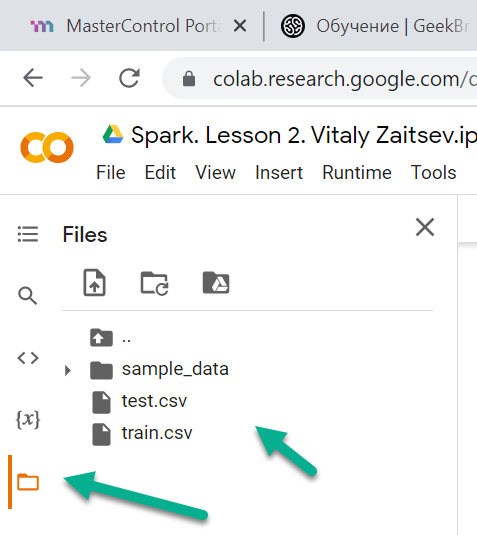

In [125]:
train = sc.textFile('/content/train.csv')

In [126]:
test = sc.textFile('/content/test.csv')

In [15]:
# Выведите содержимое каждого файла (часть строк)
###############

In [127]:
train.take(3)

['battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range',
 '842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1',
 '1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2']

In [128]:
test.take(3)

['id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi',
 '1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0',
 '2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0']

### Преобразование train и test (в float значения)

Используем функцию map 'https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.html#rdd-apis'

`RDD.map(f[, preservesPartitioning])`

Return a new RDD by applying a function to each element of this RDD



In [129]:
# На атрибутах наборов данных далее завязана логика, поэтому запомним их
train_first_row = train.first()
test_first_row = test.first()

In [130]:
train = train\
    .filter(lambda row: row != train_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])

In [131]:
test = test\
    .filter(lambda row: row != test_first_row)\
    .map(lambda row: [float(el) for el in row.split(',')])

### Объединение train и test

У нас версия 3.2.0, поэтому используем соответствующее описание RDD API 'https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.html#rdd-apis'

PS: Подсказка: использовать rdd pd.concat([train, test,], axis=0)

In [118]:
# Посмотрим - какие у нас есть атрибуты в тестовых наборах 
train_first_row

'battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range'

In [119]:
test_first_row

'id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi'

In [121]:
# Вывод:
# В train ОТСУТСТВУЕТ id
# В test ОТСУТСТВУЕТ price_range
# 
# Для последующего объединения (UNION) требуется либо добавить недостающие атрибуты (пусть со значением NULL), либо убрать различающиеся
# Оба два варианта хуже:
# в случае добавления недостающих атрибутов они будут заполнены Null 
#    (в общем случае у нас будут очень сильно неполные данные, на основании которых мы будем делать прогнозы)
# в случае отсечения атрибутов мы их "потеряем" (при этом у нас останется только рабочая выжимка данных, без пропусков и Null) 
#
# Предлагаю идти от задачи - требуется рассчитать "самое популярное соотношение сторон экрана телефона" и "плотность пикселей у экрана"
# Для этих задач id и price_range НЕ нужны -> удаляем эти недостающие в наборах атрибуты и объединяем два исходных набора в один объединённый 

In [135]:
# Перед началом запомним исходное количество записей в наборах
train.count()

2000

In [136]:
test.count()

1000

In [ ]:
# Находим одинаковые колонки в обоих наборах данных (объединяем множества названий атрибутов из двух наборов)
identical_columns = set(train_first_row.split(',')) & set(test_first_row.split(','))

# Вычисляем номера столбцов, которые различаются
train_excess_cols = [x[0] for x in enumerate(train_first_row.split(',')) if x[1] not in identical_columns] 
test_excess_cols = [x[0] for x in enumerate(test_first_row.split(',')) if x[1] not in identical_columns]

# Формируем новый заголовок будущего объединённого набора данных, сохраняя первоначальный порядок следования столбцов
united_header = [el for el in train_first_row.split(',') if el in identical_columns]
united_header = ','.join(united_header)

# Формируем сам набор
united_data = train.map(lambda row: [x[1] for x in enumerate(row) if x[0] not in train_excess_cols]) \
       .union(test.map(lambda row: [x[1] for x in enumerate(row) if x[0] not in test_excess_cols]))

In [137]:
# Проверяем результат
united_header

'battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi'

In [140]:
united_data.count()

3000

In [139]:
united_data.take(3)

[[842.0,
  0.0,
  2.2,
  0.0,
  1.0,
  0.0,
  7.0,
  0.6,
  188.0,
  2.0,
  2.0,
  20.0,
  756.0,
  2549.0,
  9.0,
  7.0,
  19.0,
  0.0,
  0.0,
  1.0],
 [1021.0,
  1.0,
  0.5,
  1.0,
  0.0,
  1.0,
  53.0,
  0.7,
  136.0,
  3.0,
  6.0,
  905.0,
  1988.0,
  2631.0,
  17.0,
  3.0,
  7.0,
  1.0,
  1.0,
  0.0],
 [563.0,
  1.0,
  0.5,
  1.0,
  2.0,
  1.0,
  41.0,
  0.9,
  145.0,
  5.0,
  6.0,
  1263.0,
  1716.0,
  2603.0,
  11.0,
  2.0,
  9.0,
  1.0,
  1.0,
  0.0]]

### Расчёт соотношения сторон телефона и экрана

In [141]:
# Выведите отсортированное распределение соотношений сторон экрана
# в разрезе широкоформатные или нет (экран широкоформатный, если соотногшение >=16:9)

In [143]:
# Запоминаем номера столбцов с шириной и высотой экрана
sc_w = [x[0] for x in enumerate(united_header.split(',')) if x[1] == 'sc_w'][0]
sc_h = [x[0] for x in enumerate(united_header.split(',')) if x[1] == 'sc_h'][0]

In [144]:
# Чистка данных, отбрасываем "мусорные" значения ширины и высоты
united_data = united_data.filter(lambda row: row[sc_w] > 0)

In [145]:
united_data.count()

2708

In [146]:
united_data = united_data.filter(lambda row: row[sc_h] > 0)

In [147]:
united_data.count()

2708

In [149]:
# Производим расчёт соотношения, высота / ширина (по всем моделям, включая широкоформатные), с сортировкой
screen_aspect_ratio = united_data.map(lambda row: (round(row[sc_h] / row[sc_w], 2), 1)).sortByKey().countByKey()

In [150]:
screen_aspect_ratio

defaultdict(int,
            {1.06: 46,
             1.07: 17,
             1.08: 28,
             1.09: 16,
             1.1: 26,
             1.11: 14,
             1.12: 35,
             1.13: 15,
             1.14: 37,
             1.15: 16,
             1.17: 47,
             1.18: 14,
             1.19: 8,
             1.2: 69,
             1.21: 17,
             1.22: 25,
             1.23: 13,
             1.25: 56,
             1.27: 27,
             1.29: 26,
             1.3: 20,
             1.31: 13,
             1.33: 54,
             1.36: 22,
             1.38: 29,
             1.4: 59,
             1.42: 12,
             1.43: 17,
             1.44: 12,
             1.45: 18,
             1.46: 10,
             1.5: 89,
             1.55: 14,
             1.56: 19,
             1.57: 15,
             1.58: 10,
             1.6: 32,
             1.62: 8,
             1.64: 12,
             1.67: 68,
             1.7: 16,
             1.71: 26,
             1.73: 8,
    

In [160]:
# И отдельно выведем инфу по широкоформатным моделям
# Делаем второй словарь, только широкоформатные модели (ключ >= 1.78)
widescreenonly = {x[0]: x[1] for x in screen_aspect_ratio.items() if x[0] >= 1.78}
# Пусть отсортируем по самым распространённыйм, по убыванию
widescreenonly = sorted(widescreenonly.items(), key=lambda item: item[1], reverse=True)

In [161]:
widescreenonly

[(2.0, 123),
 (3.0, 100),
 (6.0, 70),
 (5.0, 68),
 (2.5, 66),
 (4.0, 50),
 (2.33, 46),
 (7.0, 43),
 (4.5, 37),
 (3.5, 35),
 (2.25, 34),
 (8.0, 34),
 (1.8, 33),
 (9.0, 31),
 (2.67, 29),
 (10.0, 26),
 (2.2, 21),
 (2.17, 20),
 (2.43, 20),
 (5.5, 19),
 (11.0, 19),
 (14.0, 19),
 (2.83, 18),
 (4.25, 18),
 (17.0, 18),
 (1.86, 17),
 (2.12, 17),
 (2.6, 17),
 (4.33, 17),
 (2.57, 16),
 (3.25, 16),
 (12.0, 16),
 (1.88, 15),
 (1.9, 15),
 (3.2, 15),
 (6.33, 15),
 (8.5, 15),
 (3.33, 14),
 (3.67, 14),
 (4.67, 14),
 (5.67, 14),
 (7.5, 14),
 (13.0, 14),
 (16.0, 14),
 (1.83, 13),
 (1.89, 13),
 (2.14, 13),
 (2.4, 13),
 (5.33, 13),
 (2.29, 12),
 (2.75, 12),
 (2.8, 12),
 (6.5, 12),
 (2.38, 11),
 (3.75, 11),
 (15.0, 11),
 (3.4, 10),
 (3.6, 10),
 (19.0, 10),
 (2.11, 9),
 (3.17, 9),
 (9.5, 9),
 (18.0, 9),
 (1.78, 8),
 (4.75, 8),
 (2.71, 7),
 (3.8, 4)]

### Расчёт распределения плотности пикселей (точек на дюйм (ppi))

In [162]:
# Опять готовим данные
# повторяем упражнение, определяем номера столбцов с шириной и высотой экрана
sc_w = [x[0] for x in enumerate(united_header.split(',')) if x[1] == 'sc_w'][0]
sc_h = [x[0] for x in enumerate(united_header.split(',')) if x[1] == 'sc_h'][0]

# Определяем номера столбцов с пикселями
px_width = [x[0] for x in enumerate(united_header.split(',')) if x[1] == 'px_width'][0]
px_height = [x[0] for x in enumerate(united_header.split(',')) if x[1] == 'px_height'][0]

In [ ]:
# Оставляем только положительные значения

In [163]:
# Удаляем строки с нулевыми данными
united_data = united_data.filter(lambda row: row[sc_w] > 0)
united_data = united_data.filter(lambda row: row[sc_h] > 0)

In [164]:
united_data = united_data.filter(lambda row: row[px_width] > 0)
united_data = united_data.filter(lambda row: row[px_height] > 0)

In [165]:
# Посмотрим - сколько осталось строк в итоговом датасете
united_data.count()

2705

In [167]:
# Рассчитываем магию PPI
PPI = united_data.map(lambda row: \
                          (\
                            round( \
                              ((row[px_width] ** 2 + row[px_height] ** 2) ** 0.5) / \
                              (((row[sc_w] ** 2 + row[sc_h] ** 2) ** 0.5) * 0.3937) \
                                    , 0) \
                           , 1) \
              ).sortByKey().countByKey()

In [168]:
# Выводим PPI
PPI

defaultdict(int,
            {56.0: 1,
             61.0: 3,
             63.0: 1,
             64.0: 1,
             65.0: 1,
             67.0: 2,
             68.0: 1,
             69.0: 1,
             70.0: 1,
             71.0: 1,
             72.0: 2,
             73.0: 2,
             74.0: 2,
             76.0: 2,
             77.0: 1,
             78.0: 2,
             79.0: 6,
             80.0: 5,
             81.0: 3,
             82.0: 6,
             83.0: 8,
             84.0: 6,
             85.0: 4,
             86.0: 3,
             87.0: 8,
             88.0: 5,
             89.0: 5,
             90.0: 4,
             91.0: 3,
             92.0: 5,
             93.0: 6,
             94.0: 3,
             95.0: 4,
             96.0: 7,
             97.0: 5,
             98.0: 2,
             99.0: 5,
             100.0: 5,
             101.0: 4,
             102.0: 7,
             103.0: 6,
             104.0: 3,
             105.0: 6,
             106.0: 3,
        

## JOIN

### Задание
Повторите вышеописанное задание с помощью одной из функций ниже (отдельно рассчитайте для train и test, затем объедините результат)

Пример для двух RDDs: (rdd = {(1, 2), (3, 4), (3, 6)} other = {(3, 9)})

Имя функции |	Purpose |	Example |	Result
------------- |	------- |	------- |	------
subtractByKey |Remove elements with a key present in the other RDD.| rdd.subtractByKey(other) | {(1, 2)}
join | Perform an inner join between two RDDs. | rdd.join(other) | {(3, (4, 9)), (3, (6, 9))}
rightOuterJoin | Perform a join between two RDDs where the key must be present in the first RDD. | rdd.rightOuterJoin(other) | {(3,(Some(4),9)), (3,(Some(6),9))}leftOuterJoin | Perform a join between two RDDs where the key must be present in the other RDD. | rdd.leftOuterJoin(other) | {(1,(2,None)), (3,(4,Some(9))), (3,(6,Some(9)))}
cogroup | Group data from both RDDs sharing the same key. | rdd.cogroup(other) | {(1,([2],[])), (3,([4, 6],[9]))}


### Реализация

In [186]:
train_first_row

'battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range'

In [187]:
test_first_row

'id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi'

In [188]:
train.count()

2000

In [189]:
test.count()

1000

In [190]:
# Подготавливаем для работы train

# Определяем номера столбцов с шириной и высотой экрана
tr_sc_w = [x[0] for x in enumerate(train_first_row.split(',')) if x[1] == 'sc_w'][0]
tr_sc_h = [x[0] for x in enumerate(train_first_row.split(',')) if x[1] == 'sc_h'][0]

# Определяем номера столбцов с пикселями
tr_px_width = [x[0] for x in enumerate(train_first_row.split(',')) if x[1] == 'px_width'][0]
tr_px_height = [x[0] for x in enumerate(train_first_row.split(',')) if x[1] == 'px_height'][0]

# Оставляем строки с положительными значениями 
jtrain = train.filter(lambda row: row[tr_sc_w] > 0)
jtrain = jtrain.filter(lambda row: row[tr_sc_h] > 0)
jtrain = jtrain.filter(lambda row: row[tr_px_width] > 0)
jtrain = jtrain.filter(lambda row: row[tr_px_height] > 0)


In [191]:
# Подготавливаем для работы test

# Определяем номера столбцов с шириной и высотой экрана
te_sc_w = [x[0] for x in enumerate(test_first_row.split(',')) if x[1] == 'sc_w'][0]
te_sc_h = [x[0] for x in enumerate(test_first_row.split(',')) if x[1] == 'sc_h'][0]

# Определяем номера столбцов с пикселями
te_px_width = [x[0] for x in enumerate(test_first_row.split(',')) if x[1] == 'px_width'][0]
te_px_height = [x[0] for x in enumerate(test_first_row.split(',')) if x[1] == 'px_height'][0]

# Оставляем строки с положительными значениями 
jtest = test.filter(lambda row: row[te_sc_w] > 0)
jtest = jtest.filter(lambda row: row[te_sc_h] > 0)
jtest = jtest.filter(lambda row: row[te_px_width] > 0)
jtest = jtest.filter(lambda row: row[te_px_height] > 0)

In [192]:
jtrain.count()

1819

In [193]:
jtest.count()

886

In [194]:
# Вычисляем соотношение сторон для train и test
tr_screen_aspect_ratio = jtrain.map(lambda row: (round(row[tr_sc_h] / row[tr_sc_w], 2), 1)).sortByKey().countByKey()
te_screen_aspect_ratio = jtest.map(lambda row: (round(row[te_sc_h] / row[te_sc_w], 2), 1)).sortByKey().countByKey()

# Вычисляем PPI для train и test
tr_PPI = jtrain.map(lambda row: \
                          (\
                            round( \
                              ((row[tr_px_width] ** 2 + row[tr_px_height] ** 2) ** 0.5) / \
                              (((row[tr_sc_w] ** 2 + row[tr_sc_h] ** 2) ** 0.5) * 0.3937) \
                                    , 0) \
                           , 1) \
              ).sortByKey().countByKey()

te_PPI = jtest.map(lambda row: \
                          (\
                            round( \
                              ((row[te_px_width] ** 2 + row[te_px_height] ** 2) ** 0.5) / \
                              (((row[te_sc_w] ** 2 + row[te_sc_h] ** 2) ** 0.5) * 0.3937) \
                                    , 0) \
                           , 1) \
              ).sortByKey().countByKey()

In [195]:
# Создаем объекты RDD, на основании полученных данных о соотношении сторон и PPI
train_subtract = sc.parallelize(tr_screen_aspect_ratio.items())
test_subtract = sc.parallelize(te_screen_aspect_ratio.items())

train_join = sc.parallelize(tr_PPI.items())
test_join = sc.parallelize(te_PPI.items())

In [196]:
train_subtract.subtractByKey(test_subtract).collect()

[(1.09, 16)]

In [197]:
train_join.join(test_join).sortByKey().collect()

[(61.0, (1, 2)),
 (73.0, (1, 1)),
 (74.0, (1, 1)),
 (76.0, (1, 1)),
 (79.0, (4, 2)),
 (80.0, (1, 4)),
 (82.0, (4, 2)),
 (83.0, (4, 4)),
 (84.0, (5, 1)),
 (85.0, (3, 1)),
 (86.0, (2, 1)),
 (87.0, (4, 4)),
 (88.0, (2, 3)),
 (89.0, (2, 3)),
 (90.0, (3, 1)),
 (91.0, (2, 1)),
 (92.0, (3, 2)),
 (93.0, (2, 4)),
 (94.0, (2, 1)),
 (95.0, (3, 1)),
 (97.0, (2, 3)),
 (98.0, (1, 1)),
 (99.0, (4, 1)),
 (100.0, (3, 2)),
 (102.0, (5, 2)),
 (103.0, (4, 2)),
 (105.0, (5, 1)),
 (106.0, (2, 1)),
 (107.0, (4, 1)),
 (108.0, (1, 1)),
 (109.0, (3, 3)),
 (110.0, (5, 3)),
 (111.0, (3, 2)),
 (112.0, (3, 5)),
 (113.0, (2, 1)),
 (114.0, (4, 3)),
 (115.0, (2, 3)),
 (116.0, (5, 1)),
 (117.0, (5, 3)),
 (118.0, (5, 3)),
 (120.0, (4, 3)),
 (121.0, (6, 5)),
 (122.0, (11, 2)),
 (123.0, (4, 2)),
 (124.0, (4, 3)),
 (126.0, (4, 2)),
 (127.0, (6, 2)),
 (128.0, (9, 3)),
 (129.0, (2, 3)),
 (130.0, (1, 1)),
 (131.0, (3, 1)),
 (132.0, (8, 2)),
 (133.0, (7, 1)),
 (134.0, (3, 1)),
 (136.0, (6, 2)),
 (137.0, (8, 4)),
 (138.0, (7, 6

## DataFrame

### Задание
Теперь мы знаем про Dataframe. Нужно сделать практически всё то же самое, но используя датафрейм.

### Реализация

In [198]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, FloatType

# Считываем данные сразу с правильными типами (inferSchema). 
df_train = spark.read.csv('./train.csv',header = True, inferSchema = True)
df_test = spark.read.csv('./test.csv',header = True, inferSchema = True)

In [199]:
# Уместно посмотреть схемы данных
df_train.printSchema()

root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)
 |-- price_range: integer (nullable = true)



In [200]:
df_test.printSchema()

root
 |-- id: integer (nullable = true)
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)



In [201]:
# Помним, что атрибуты-столбцы различаются
# Находим общие столбцы в обоих файлах
ident_columns = set(df_train.columns) & set(df_test.columns)

# Удаляем различающиеся столбцы из обоих dataframe'ов
df_train = df_train.drop(*(set(df_train.columns) - ident_columns))
df_test = df_test.drop(*(set(df_test.columns) - ident_columns))

# Объединяем данные
df_data = df_train.union(df_test)

In [ ]:
# Немного статистики - что у нас получилось

In [202]:
df_train.count()

2000

In [203]:
df_test.count()

1000

In [204]:
df_data.count()

3000

In [205]:
df_data.printSchema()

root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)



In [206]:
# Добавляем новые колонки с соотношением сторон и плотностью пикселей

# Оставляем только положительные значения 
df_data = df_data.select('*').where('sc_h > 0 and sc_w > 0 and px_height > 0 and px_width > 0')

# Добавляем столбец с соотношением сторон
df_data = df_data.withColumn('screen_ratio', F.round((F.col('sc_h')/F.col('sc_w')).cast(FloatType()), 2))

# Создаём колонки с соотношением сторон и плотностью пикселей
df_data = df_data.withColumn('ppi', F.round( \
                                            (F.sqrt((F.pow(F.col('px_width'), 2) + F.pow(F.col('px_height'), 2))) / \
                                            (F.sqrt(F.pow(F.col('sc_w'), 2) + F.pow(F.col('sc_h'), 2)) * 0.3937)) \
                                            .cast(FloatType()), 0))

In [207]:
df_data.count()

2705

In [208]:
df_data.printSchema()

root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)
 |-- screen_ratio: float (nullable = true)
 |-- ppi: float (nullable = true)



In [209]:
df_data.select('battery_power', 'sc_h', 'sc_w', 'screen_ratio', 'px_width', 'px_height', 'ppi').show(10)

+-------------+----+----+------------+--------+---------+-----+
|battery_power|sc_h|sc_w|screen_ratio|px_width|px_height|  ppi|
+-------------+----+----+------------+--------+---------+-----+
|          842|   9|   7|        1.29|     756|       20|168.0|
|         1021|  17|   3|        5.67|    1988|      905|321.0|
|          563|  11|   2|         5.5|    1716|     1263|484.0|
|          615|  16|   8|         2.0|    1786|     1216|307.0|
|         1821|   8|   2|         4.0|    1212|     1208|527.0|
|         1859|  17|   1|        17.0|    1654|     1004|289.0|
|         1821|  13|   8|        1.63|    1018|      381|181.0|
|         1954|  16|   3|        5.33|    1149|      512|196.0|
|         1445|  17|   1|        17.0|     836|      386|137.0|
|          509|  19|  10|         1.9|    1224|     1137|198.0|
+-------------+----+----+------------+--------+---------+-----+
only showing top 10 rows



In [210]:
# Данные по широкоформатным моделям
df_data.select('screen_ratio') \
       .groupBy('screen_ratio').count() \
       .orderBy('screen_ratio').filter(F.col('screen_ratio') >= 1.77).show(10)

+------------+-----+
|screen_ratio|count|
+------------+-----+
|        1.78|    8|
|         1.8|   33|
|        1.83|   13|
|        1.86|   17|
|        1.88|   15|
|        1.89|   13|
|         1.9|   15|
|         2.0|  123|
|        2.11|    9|
|        2.13|   17|
+------------+-----+
only showing top 10 rows



In [211]:
# PPI в отсортированном виде
df_data.select('ppi').groupBy('ppi').count().orderBy('ppi').show(10)

+----+-----+
| ppi|count|
+----+-----+
|56.0|    1|
|61.0|    3|
|63.0|    1|
|64.0|    1|
|65.0|    1|
|67.0|    2|
|68.0|    1|
|69.0|    1|
|70.0|    1|
|71.0|    1|
+----+-----+
only showing top 10 rows



### И сохранение

Сохраните результат в csv sep=';', encoding='cp1251'
с колонками id, плотность пикселей и временем разговора в формате "1day 1hour 1minute"

In [212]:
from pyspark.sql import Window

# Добавляем столбец с id. Так как выводится в итоговый файл ppi, то решил к нему id привязать.
window = Window.orderBy('ppi')
df_data_final = df_data.withColumn('id', F.row_number().over(window))

# Затем добавил столбец с временем разговора

# В итоговый набор данных добавил поля id, ppi, talk_time, time (преобразованный согласно заданию talk_time)
df_data_final = df_data_final.select('id', 'ppi', 'talk_time') \
                             .withColumn('time', F.concat(F.lit('1'), F.concat_ws(' 1', \
                                                                        (F.col('talk_time') /  24).cast('int'), \
                                                                        (F.col('talk_time') % 24), \
                                                                         F.lit('0'))))

df_data_final.write.csv(path = './lesson2_result.csv', mode = 'overwrite', sep = ';', encoding = 'cp1251', header = True)

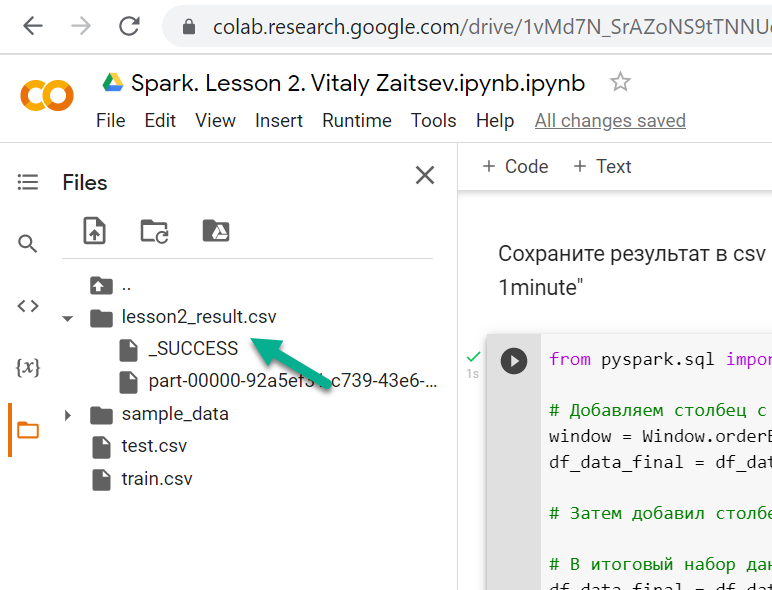

In [213]:
df_data_final.show(10)

+---+----+---------+---------+
| id| ppi|talk_time|     time|
+---+----+---------+---------+
|  1|56.0|       18|10 118 10|
|  2|61.0|       19|10 119 10|
|  3|61.0|       15|10 115 10|
|  4|61.0|       11|10 111 10|
|  5|63.0|        4| 10 14 10|
|  6|64.0|        3| 10 13 10|
|  7|65.0|       12|10 112 10|
|  8|67.0|        9| 10 19 10|
|  9|67.0|       11|10 111 10|
| 10|68.0|       16|10 116 10|
+---+----+---------+---------+
only showing top 10 rows



# END